In [19]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
from matplotlib.ticker import MaxNLocator, LogLocator, ScalarFormatter

In [100]:
# Define the base experiment folder
base_folder = "/home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experiments_tuning"

In [101]:
def smart_format(val):
    """Use scientific notation only for very small or large numbers"""
    if abs(val) < 1e-3 or abs(val) >= 2e5:
        return f"{val:.1e}"
    else:
        return f"{val:.4f}".rstrip('0').rstrip('.')  # Clean formatting for normal floats


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, MaxNLocator, LogLocator

def smart_format(val):
    if abs(val) < 1e-2 or abs(val) > 1e2:
        return f"{val:.1e}"
    else:
        return f"{val:.4f}"

def plot_metric_vs_loss(df, metric_index, loss_column="final_loss", use_log_x=False):
    metric_name = df.columns[metric_index]
    metric_values = pd.to_numeric(df.iloc[:, metric_index], errors='coerce')
    loss_values = pd.to_numeric(df[loss_column], errors='coerce')

    # Clean data
    mask = metric_values.notna() & loss_values.notna()
    metric_values = metric_values[mask]
    loss_values = loss_values[mask]

    # Start figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # === SCATTER PLOT ===
    axes[0].scatter(metric_values, loss_values, alpha=0.7, s=30)
    axes[0].set_title(f"Scatter: {metric_name} vs {loss_column}")
    axes[0].set_xlabel(metric_name)
    axes[0].set_ylabel(loss_column)
    axes[0].set_ylim(0, 8)

    if use_log_x:
        axes[0].set_xscale("log")
        axes[0].xaxis.set_major_formatter(ScalarFormatter())
        axes[0].xaxis.set_minor_formatter(ScalarFormatter())
        axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
    else:
        axes[0].xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))

    axes[0].tick_params(axis='x', rotation=45)

    # === BOX PLOT (group by bins if continuous) ===
    try:
        bins = np.histogram_bin_edges(metric_values, bins='auto')
        bin_labels = [f"{smart_format(bins[i])}–{smart_format(bins[i+1])}" for i in range(len(bins)-1)]
        bin_indices = np.digitize(metric_values, bins=bins) - 1
        bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)

        grouped = [[] for _ in bin_labels]
        for i, idx in enumerate(bin_indices):
            grouped[idx].append(loss_values.iloc[i])

        sns.boxplot(data=grouped, ax=axes[1], color='skyblue', fliersize=3)
        axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')
    except Exception as e:
        print("Boxplot binning failed:", e)

    axes[1].set_title(f"Box Plot: {loss_column} grouped by {metric_name}")
    axes[1].set_xlabel(metric_name)
    axes[1].set_ylabel(loss_column)

    plt.tight_layout()
    plt.show()


In [103]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import numpy as np
import pandas as pd
import os

def smart_format(val):
    if abs(val) < 1e-2 or abs(val) > 1e2:
        return f"{val:.1e}"
    else:
        return f"{val:.4f}"

def save_scatter_plot(df, metric_name, loss_column="best_loss", filename="scatter_plot.pdf", use_log_x=False):
    if metric_name not in df.columns:
        print(f"Metric '{metric_name}' not found in DataFrame.")
        return

    metric_values = pd.to_numeric(df[metric_name], errors='coerce')
    loss_values = pd.to_numeric(df[loss_column], errors='coerce')

    # Drop invalid rows
    mask = metric_values.notna() & loss_values.notna()
    metric_values = metric_values[mask]
    loss_values = loss_values[mask]

    # Create figure
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(metric_values, loss_values, alpha=0.7, s=30)
    ax.set_title(f"Scatter: {metric_name} vs {loss_column}")
    ax.set_xlabel(metric_name)
    ax.set_ylabel(loss_column)
    ax.set_ylim(0, 8)

    if use_log_x:
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(ScalarFormatter())
    else:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10, prune='both'))

    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()

    # Save to PDF
    fig.savefig(filename)
    plt.close(fig)
    print(f"Scatter plot saved to {filename}")


In [105]:
# Prepare containers
data = []
summary = []

# Iterate over all runs inside 'runs/'
for run_name in os.listdir(base_folder):
    run_path = os.path.join(base_folder, run_name)
    print(f"Processing {run_name}...")

    # Load the event file
    ea = event_accumulator.EventAccumulator(run_path)
    try:
        ea.Reload()
    except Exception as e:
        print(f"Failed to load {run_path}: {e}")
        continue

    # Extract hyperparameters from text (tensor) entry
    try:
        text_events = ea.Tensors("hyperparameters/text_summary")
        if text_events:
            text_val = text_events[-1].tensor_proto.string_val[0].decode("utf-8")
            hyperparam_lines = text_val.strip().split("\n")[2:]  # skip markdown headers
            hyperparams = {line.split("|")[1]: line.split("|")[2] for line in hyperparam_lines if "|" in line}
        else:
            hyperparams = {}
    except Exception as e:
        hyperparams = {}
        print(f"Failed to parse hyperparameters from {run_path}: {e}")

    # Extract scalar loss
    try:
        loss_events = ea.Scalars("losses/test_loss")
        final_loss = loss_events[-1].value
        best_loss = min(loss_events, key=lambda e: e.value)
        best_value = best_loss.value
        best_step = best_loss.step
        is_best = final_loss == best_value
    except Exception as e:
        final_loss = None
        best_value = None
        best_step = None
        is_best = False
        print(f"Failed to extract loss from {run_path}: {e}")

    # Collect results
    entry = {
        "run_name": run_name,
        "final_loss": final_loss,
        "best_loss": best_value,
        "best_step": best_step,
        "is_best_final": is_best,
    }
    entry.update(hyperparams)
    data.append(entry)

    # Create human-readable summary
    status = "Best" if is_best else f"Best was {best_value} at step {best_step}"
    summary.append(f"{run_name}: Final loss = {final_loss} → {status}")

# Create dataframe
df = pd.DataFrame(data)

index_keys = {}
for index, key in enumerate(df.columns):
    index_keys[key] = index

Processing experiment073...
Failed to parse hyperparameters from /home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experiments_tuning/experiment073: 'Key hyperparameters/text_summary was not found in Reservoir'
Failed to extract loss from /home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experiments_tuning/experiment073: 'Key losses/test_loss was not found in Reservoir'
Processing experiment040...
Failed to parse hyperparameters from /home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experiments_tuning/experiment040: 'Key hyperparameters/text_summary was not found in Reservoir'
Failed to extract loss from /home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experiments_tuning/experiment040: 'Key losses/test_loss was not found in Reservoir'
Processing experiment063...
Failed to parse hyperparameters from /home/jeauscq/Desktop/Resultados para presentar/1.HyperparameterStudy/HPT-1/experimen

# Best configuration

In [106]:
best_row = df.loc[df['best_loss'] == df['best_loss'].min()]
config = {}
print("Best hyperparameters configuration:\n")
for col in best_row.columns:
    print(f"{col}: {best_row.iloc[0][col]}")
    try:
        config[col] = float(best_row.iloc[0][col])
    except:
        config[col] = best_row.iloc[0][col]

Best hyperparameters configuration:



IndexError: single positional indexer is out-of-bounds

In [57]:
# Genera una función que obtenaa un histograma de los valores de best_loss y su frecuencia
def plot_best_loss_histogram(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['best_loss'], bins=30, kde=True, color='blue', stat='density')
    plt.title('Distribution of Best Loss Values')
    plt.xlabel('Best Loss Value')
    plt.ylabel('Density')
    plt.savefig("best_loss_histogram.pdf")
    plt.grid(True)
    plt.show()

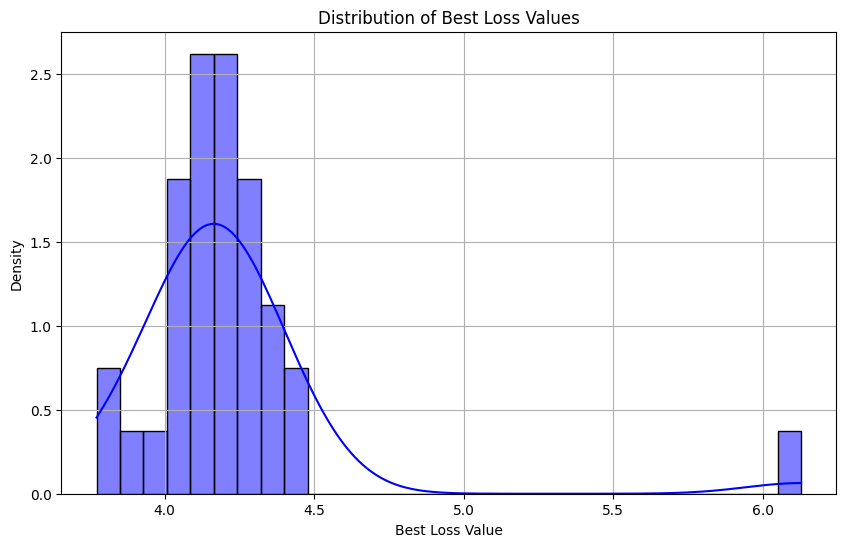

In [58]:
plot_best_loss_histogram(df)

# ent_coef 

Entropy coefficient to encourage exploration.

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


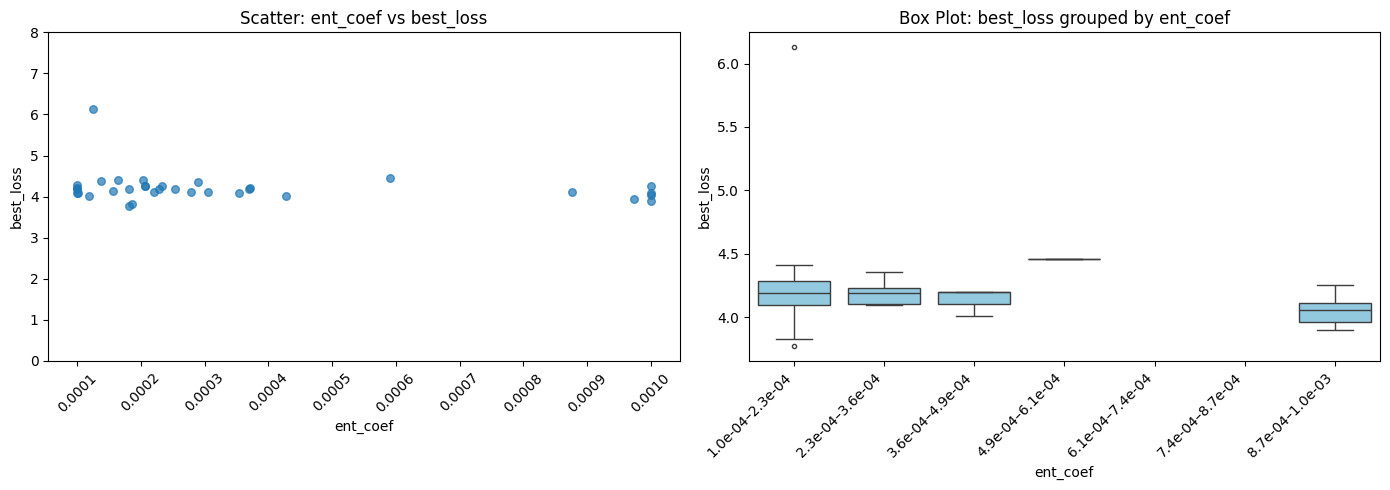

Scatter plot saved to scatter_ent_coef_vs_best_loss.pdf


In [81]:
plot_metric_vs_loss(df, index_keys['ent_coef'], "best_loss")
save_scatter_plot(df, "ent_coef", "best_loss", "scatter_ent_coef_vs_best_loss.pdf")

# batch_size
Number of collected samples per PPO rollout batch

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


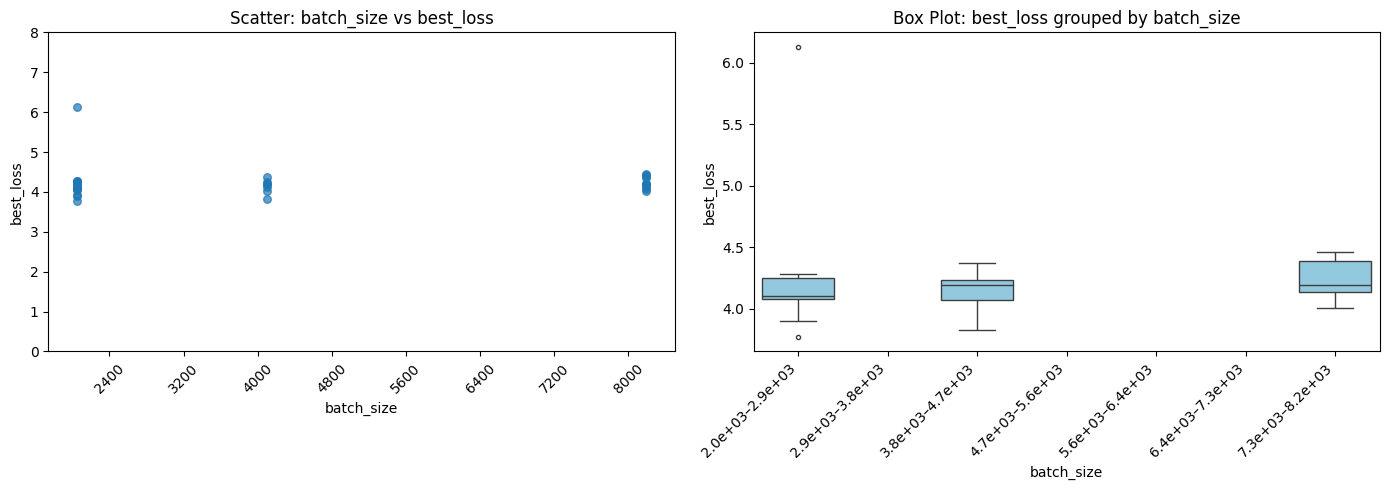

Scatter plot saved to scatter_batch_size_vs_best_loss.pdf


In [82]:
plot_metric_vs_loss(df, index_keys['batch_size'], "best_loss")
save_scatter_plot(df, "batch_size", "best_loss", "scatter_batch_size_vs_best_loss.pdf")

# num_minibatches
Number of minibatches to split batch_size during optimization

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


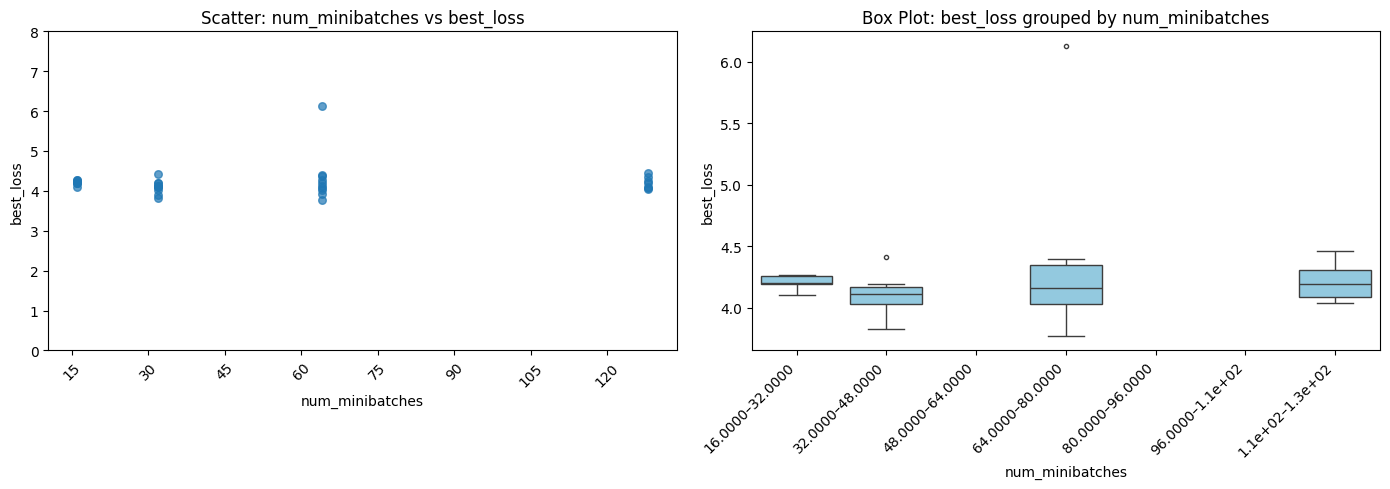

Scatter plot saved to scatter_num_minibatches_vs_best_loss.pdf


In [83]:
plot_metric_vs_loss(df, index_keys['num_minibatches'], "best_loss")
save_scatter_plot(df, "num_minibatches", "best_loss", "scatter_num_minibatches_vs_best_loss.pdf")

# num_envs
Number of parallel environments for faster data collection

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


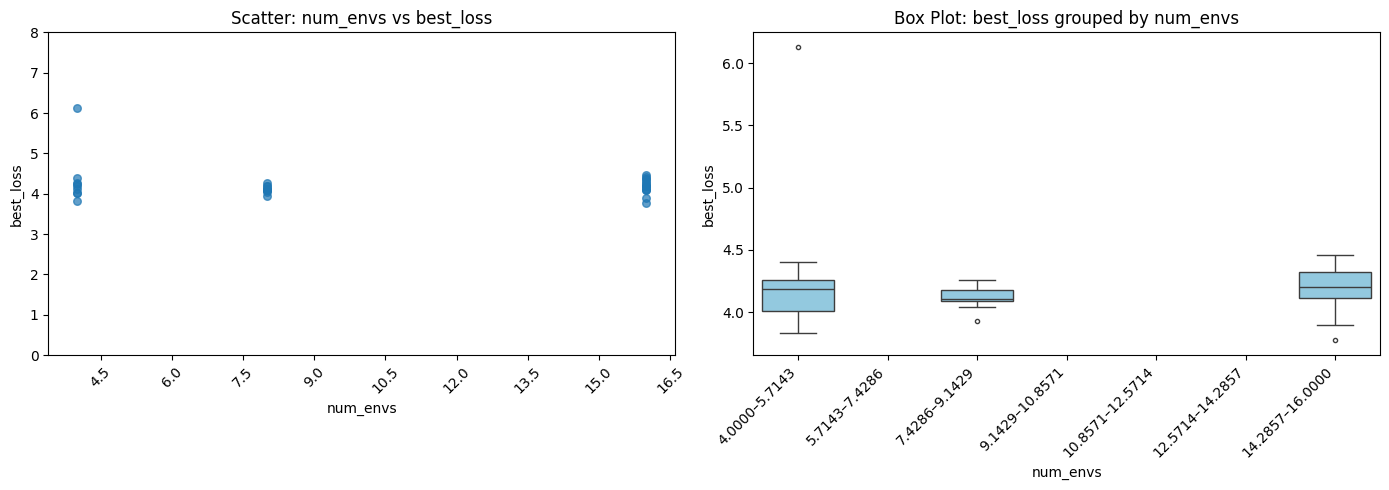

Scatter plot saved to scatter_num_envs_vs_best_loss.pdf


In [84]:
plot_metric_vs_loss(df, index_keys['num_envs'], "best_loss")
save_scatter_plot(df, "num_envs", "best_loss", "scatter_num_envs_vs_best_loss.pdf")

# update_epochs

Number of optimization epochs per PPO update


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


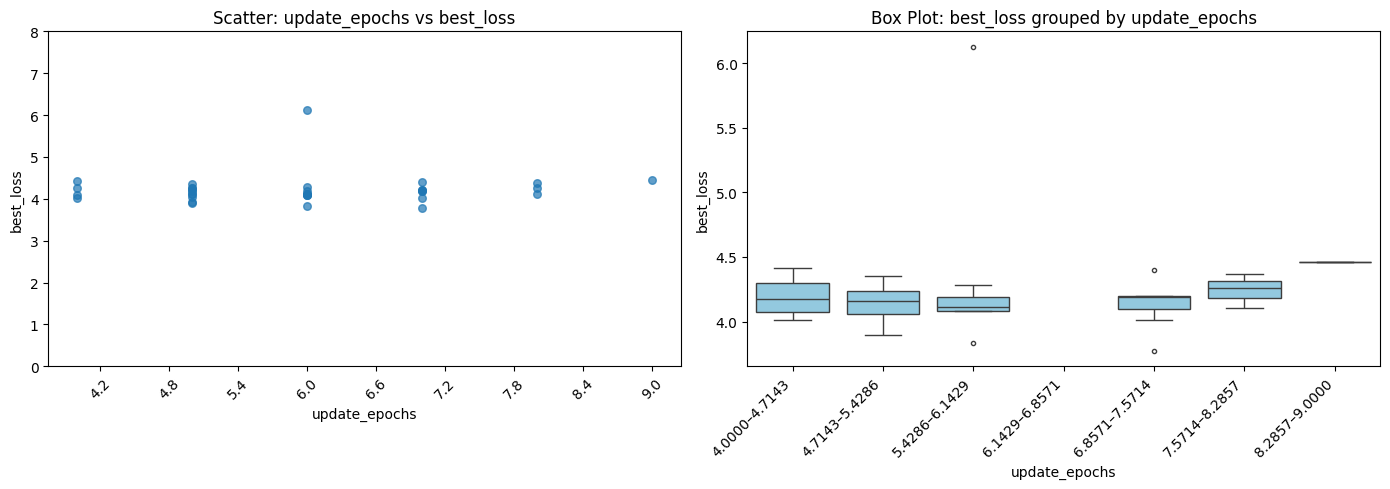

Scatter plot saved to scatter_update_epochs_vs_best_loss.pdf


In [85]:
plot_metric_vs_loss(df, index_keys['update_epochs'], "best_loss")
save_scatter_plot(df, "update_epochs", "best_loss", "scatter_update_epochs_vs_best_loss.pdf")

# hidden_dim

Hidden layer size for the GRU layer of policy, value and discriminator networks


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


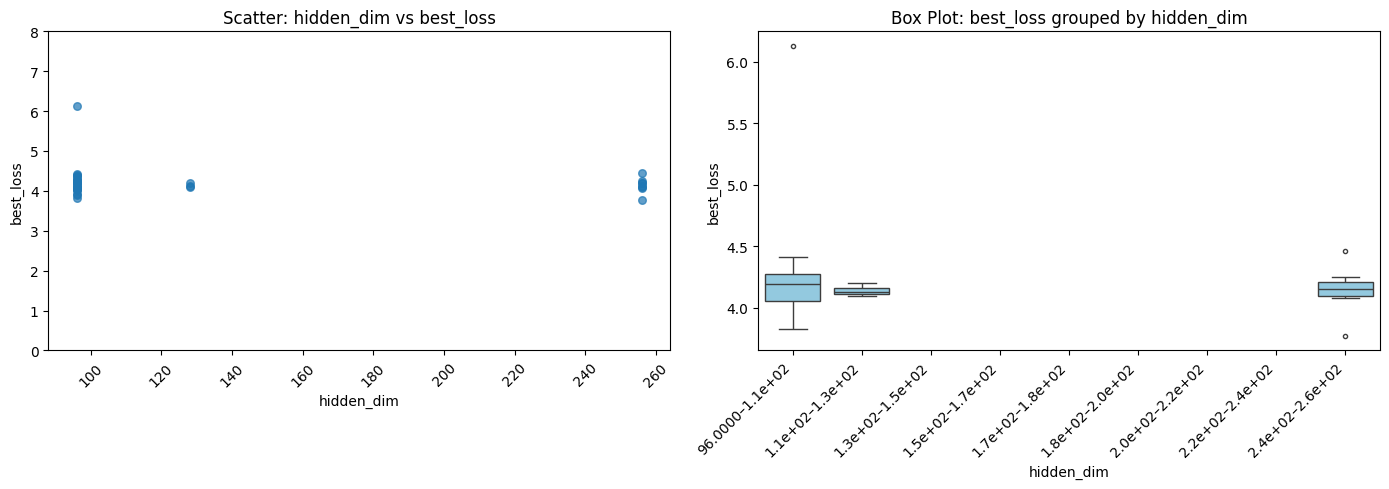

Scatter plot saved to scatter_hidden_dim_vs_best_loss.pdf


In [86]:
plot_metric_vs_loss(df, index_keys['hidden_dim'], "best_loss")
save_scatter_plot(df, "hidden_dim", "best_loss", "scatter_hidden_dim_vs_best_loss.pdf")

# num_heads

Number of heads (for multi-head discriminators ensemble) 


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


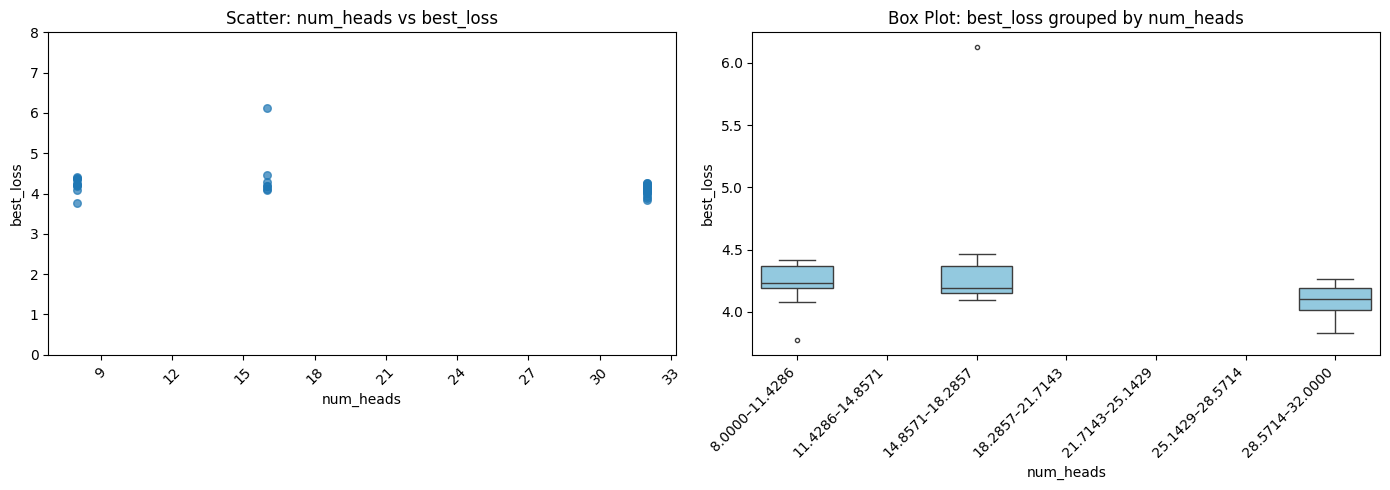

Scatter plot saved to scatter_num_heads_vs_best_loss.pdf


In [87]:
plot_metric_vs_loss(df, index_keys['num_heads'], "best_loss")
save_scatter_plot(df, "num_heads", "best_loss", "scatter_num_heads_vs_best_loss.pdf")

# lambda_gp

Gradient penalty coefficient for discriminator regularization


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


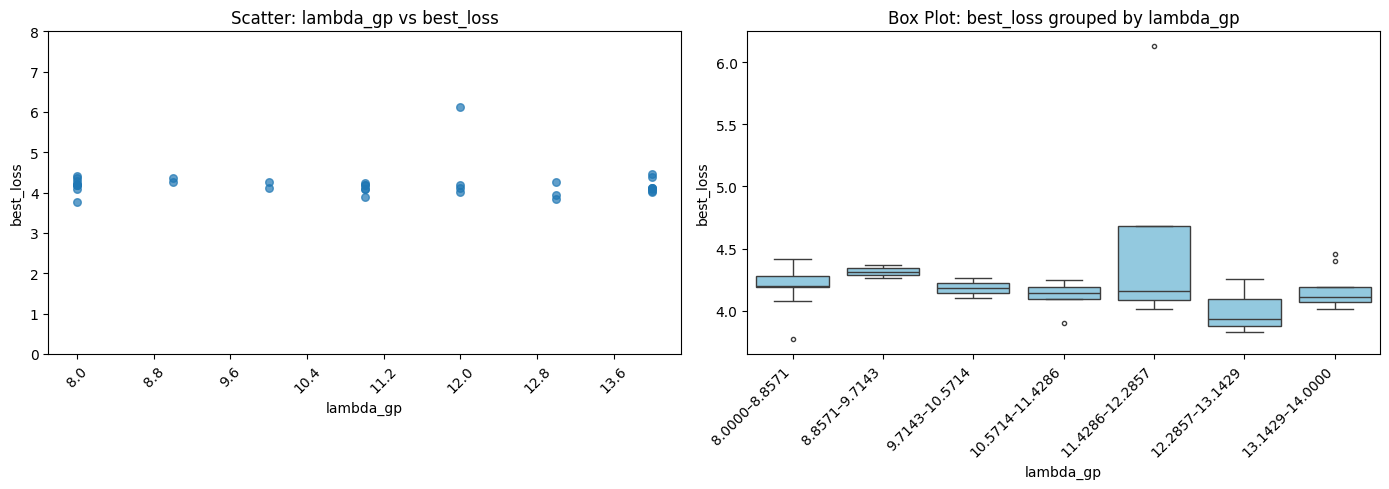

Scatter plot saved to scatter_lambda_gp_vs_best_loss.pdf


In [88]:
plot_metric_vs_loss(df, index_keys['lambda_gp'], "best_loss")
save_scatter_plot(df, "lambda_gp", "best_loss", "scatter_lambda_gp_vs_best_loss.pdf")

# batch_disc

Size of discriminator training batch for real and generated samples


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


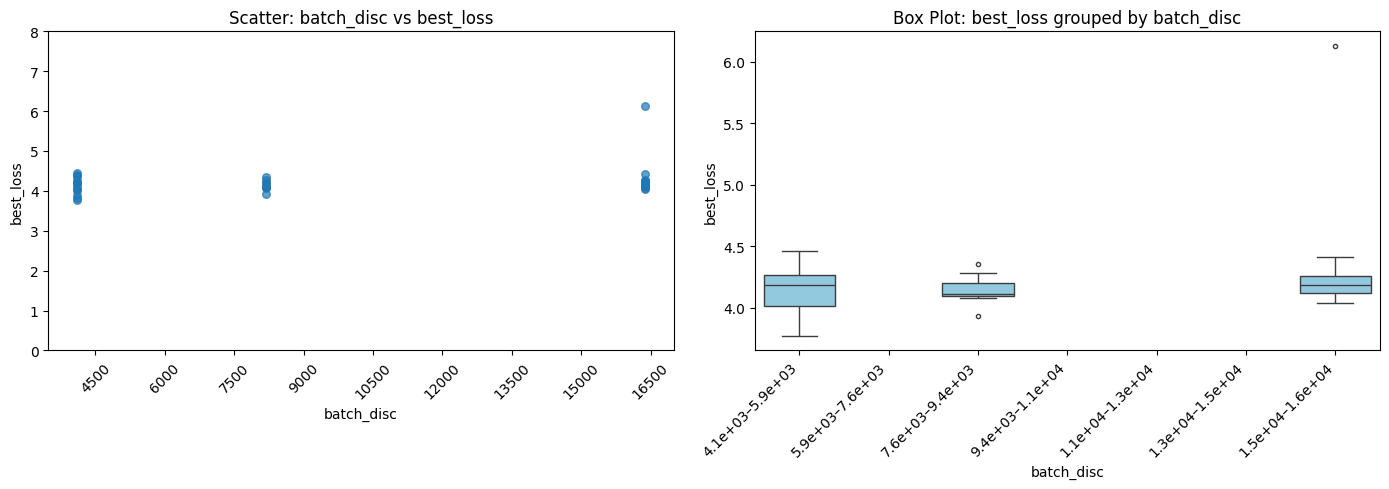

Scatter plot saved to scatter_batch_disc_vs_best_loss.pdf


In [89]:
plot_metric_vs_loss(df, index_keys['batch_disc'], "best_loss")
save_scatter_plot(df, "batch_disc", "best_loss", "scatter_batch_disc_vs_best_loss.pdf")

# minibatch_disc

Number of minibatches for discriminator update


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


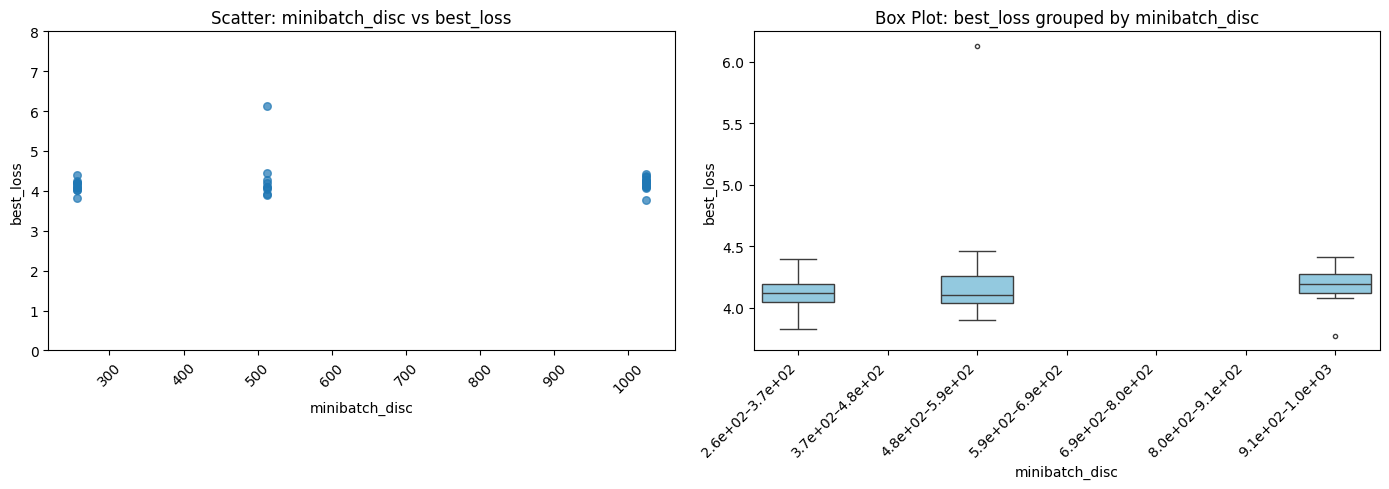

Scatter plot saved to scatter_minibatch_disc_vs_best_loss.pdf


In [90]:
plot_metric_vs_loss(df, index_keys['minibatch_disc'], "best_loss")
save_scatter_plot(df, "minibatch_disc", "best_loss", "scatter_minibatch_disc_vs_best_loss.pdf")

# std_init

Initial standard deviations for policy output. The value for the second joint is a third of this output.


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


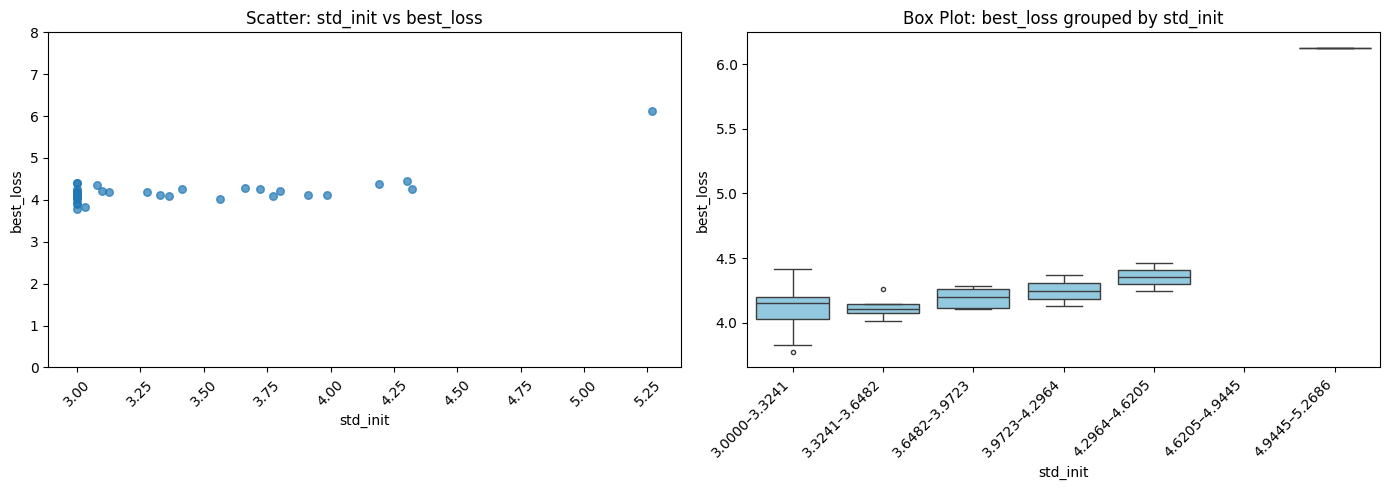

Scatter plot saved to scatter_std_init_vs_best_loss.pdf


In [91]:
plot_metric_vs_loss(df, index_keys['std_init'], "best_loss")
save_scatter_plot(df, "std_init", "best_loss", "scatter_std_init_vs_best_loss.pdf")

# lr_pol

Learning rate for the policy network


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


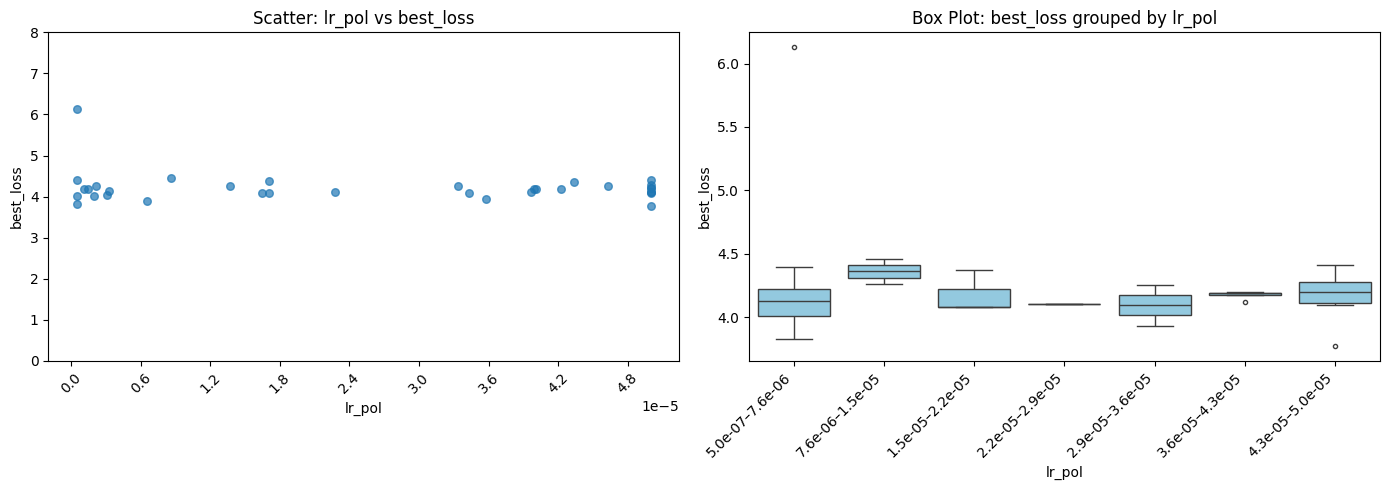

Scatter plot saved to scatter_lr_pol_vs_best_loss.pdf


In [92]:
plot_metric_vs_loss(df, index_keys['lr_pol'], "best_loss")
save_scatter_plot(df, "lr_pol", "best_loss", "scatter_lr_pol_vs_best_loss.pdf")

# lr_val

Learning rate for the value network


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


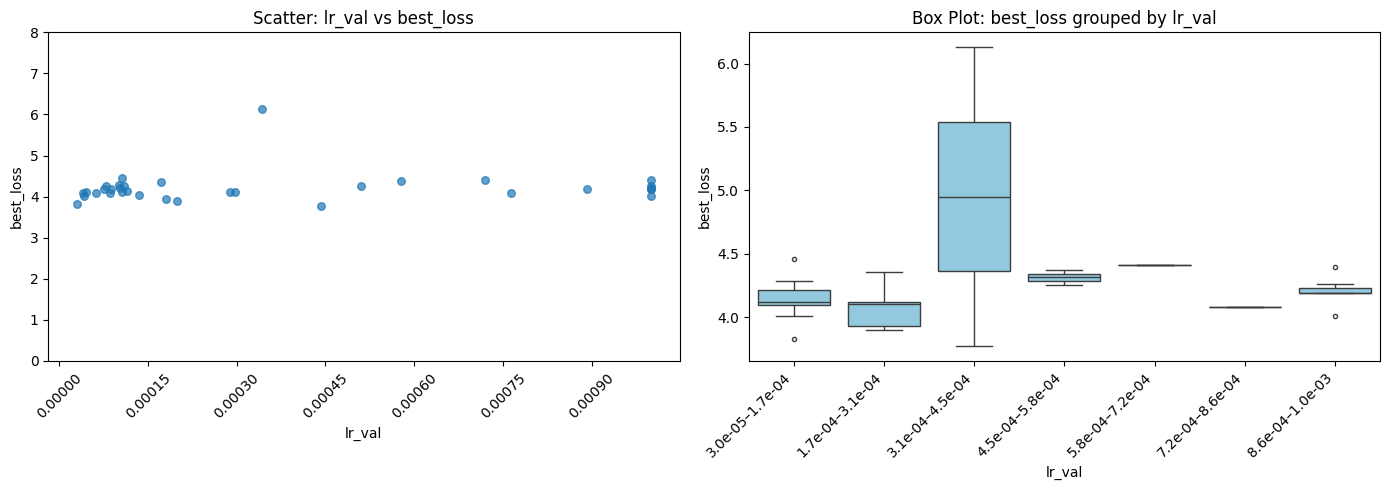

Scatter plot saved to scatter_lr_val_vs_best_loss.pdf


In [93]:
plot_metric_vs_loss(df, index_keys['lr_val'], "best_loss")
save_scatter_plot(df, "lr_val", "best_loss", "scatter_lr_val_vs_best_loss.pdf")

# lr_disc
Learning rate for the discriminator network


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


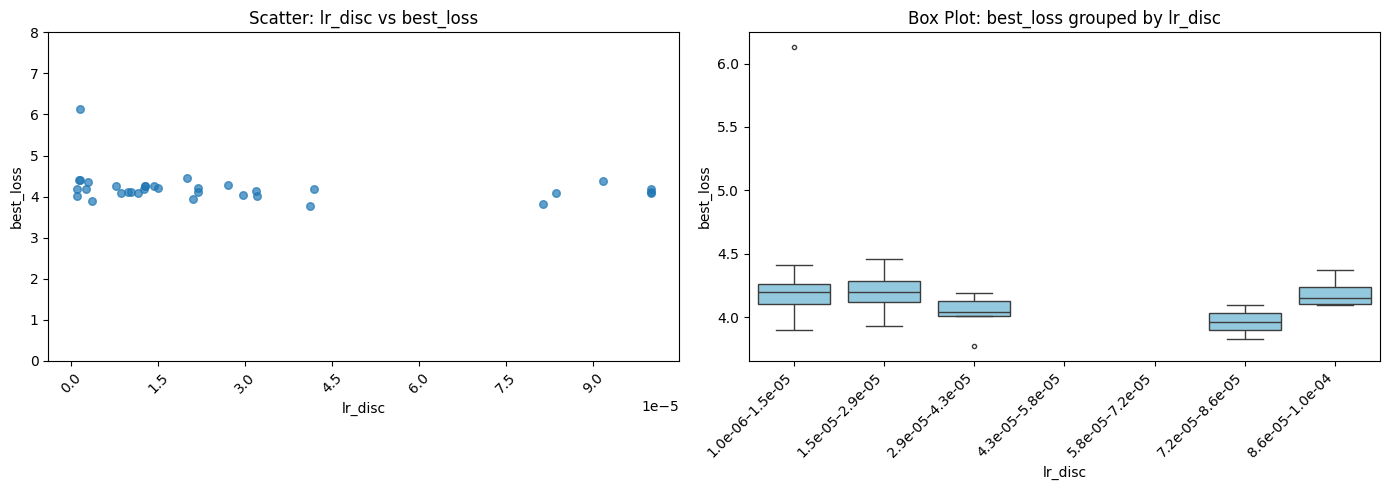

Scatter plot saved to scatter_lr_disc_vs_best_loss.pdf


In [94]:
plot_metric_vs_loss(df, index_keys['lr_disc'], "best_loss")
save_scatter_plot(df, "lr_disc", "best_loss", "scatter_lr_disc_vs_best_loss.pdf")

# gamma

Discount factor for future rewards


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


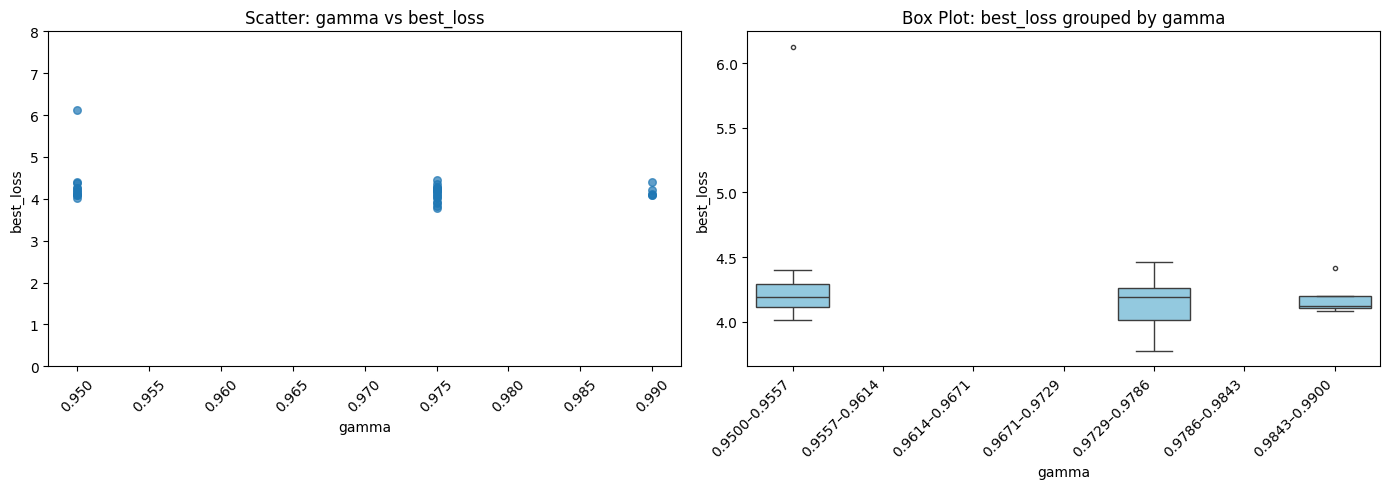

Scatter plot saved to scatter_gamma_vs_best_loss.pdf


In [95]:
plot_metric_vs_loss(df, index_keys['gamma'], "best_loss")
save_scatter_plot(df, "gamma", "best_loss", "scatter_gamma_vs_best_loss.pdf")

# N

Number of past states included in observation

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


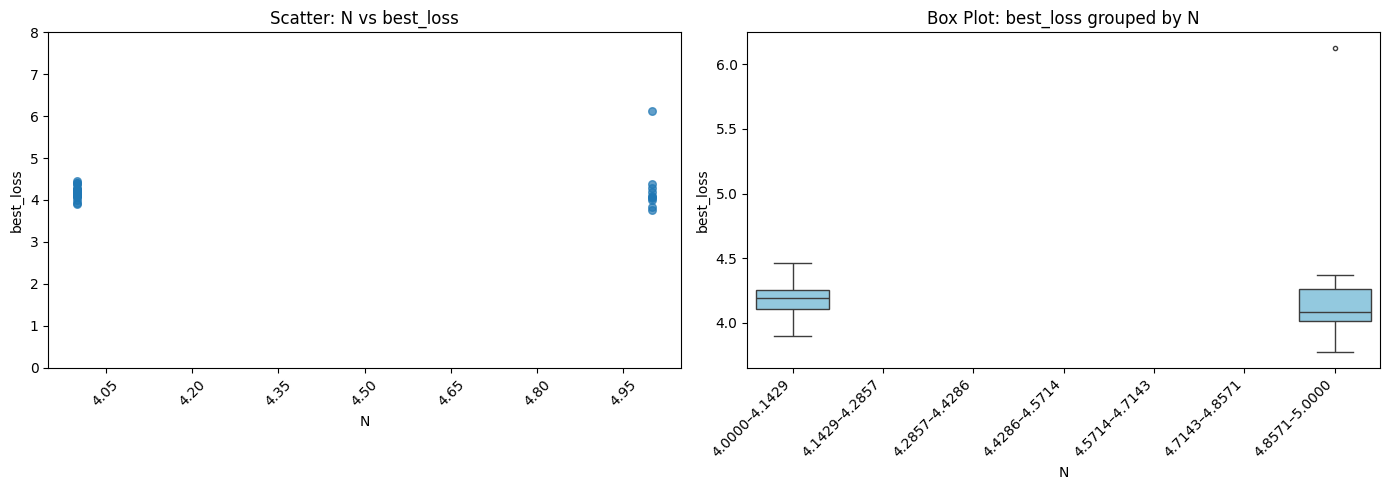

Scatter plot saved to scatter_N_vs_best_loss.pdf


In [96]:
plot_metric_vs_loss(df, index_keys['N'], "best_loss")
save_scatter_plot(df, "N", "best_loss", "scatter_N_vs_best_loss.pdf")

# M

Number of future desired states included in observation


/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


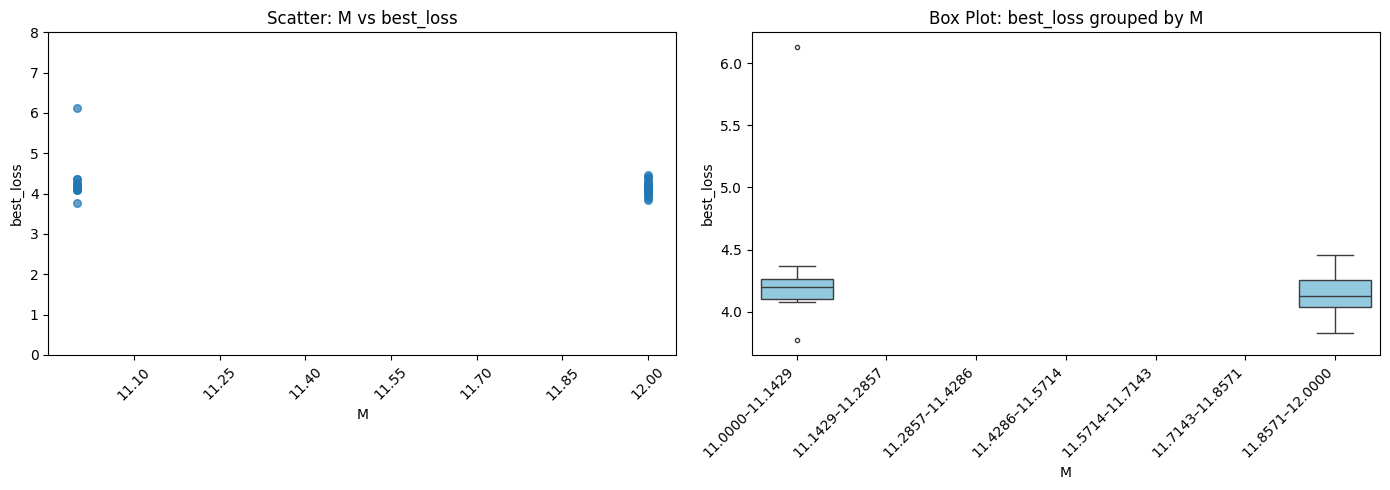

Scatter plot saved to scatter_M_vs_best_loss.pdf


In [97]:
plot_metric_vs_loss(df, index_keys['M'], "best_loss")
save_scatter_plot(df, "M", "best_loss", "scatter_M_vs_best_loss.pdf")

# num_params_policy

Number of trainable parameters for the policy and the value

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


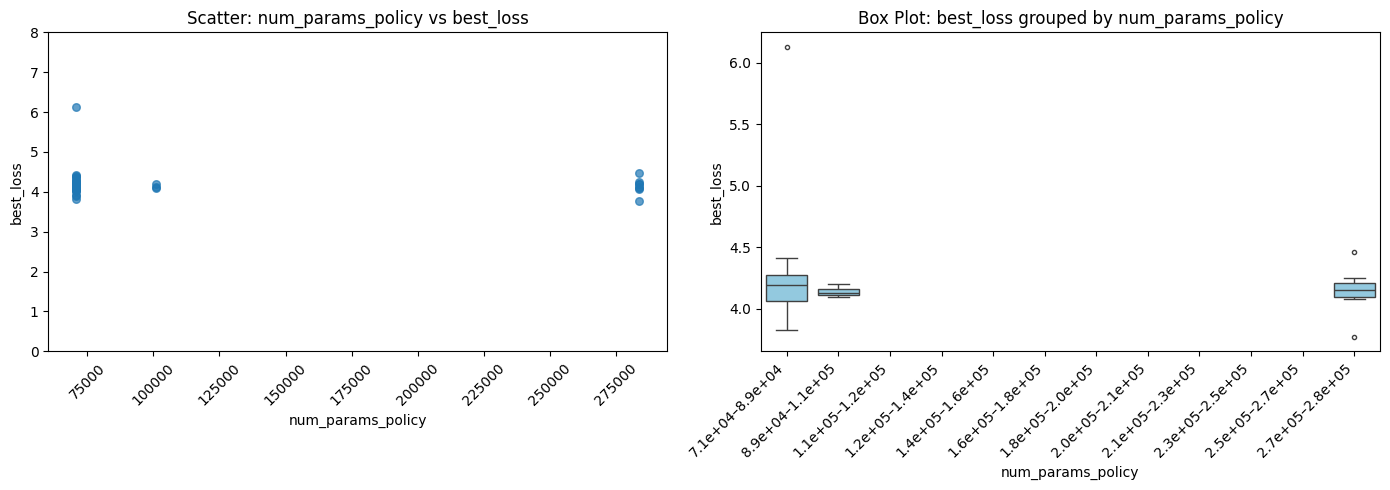

Scatter plot saved to scatter_num_params_policy_vs_best_loss.pdf


In [98]:
plot_metric_vs_loss(df, index_keys['num_params_policy'], "best_loss")
save_scatter_plot(df, "num_params_policy", "best_loss", "scatter_num_params_policy_vs_best_loss.pdf")   

# num_params_disc

Number of trainable parameters for the discriminator

/tmp/ipykernel_11757/640383734.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(bin_labels, rotation=45, ha='right')


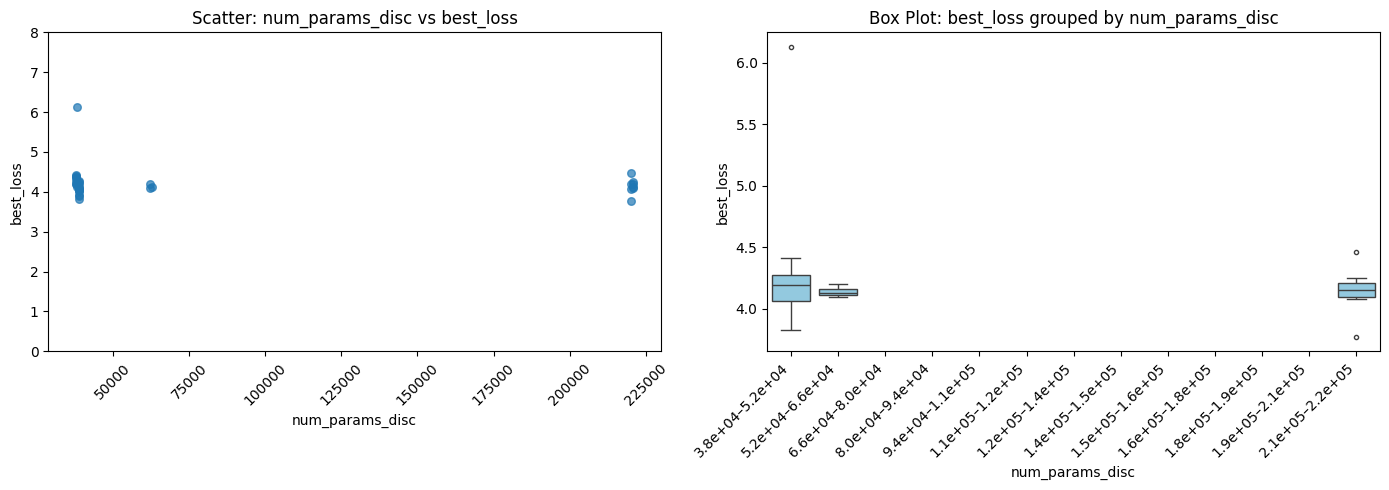

Scatter plot saved to scatter_num_params_disc_vs_best_loss.pdf


In [99]:
plot_metric_vs_loss(df, index_keys['num_params_disc'], "best_loss")
save_scatter_plot(df, "num_params_disc", "best_loss", "scatter_num_params_disc_vs_best_loss.pdf")

In [78]:

config["batch_size"] = int(config["batch_size"])
config["num_minibatches"] = int(config["num_minibatches"])
config["num_envs"] =  int(config["num_envs"])
config["update_epochs"] = int(config["update_epochs"])
config["hidden_dim"] = int(config["hidden_dim"])
config["num_heads"] = int(config["num_heads"])
config["lambda_gp"] = int(config["lambda_gp"])
config["batch_disc"] =  int(config["batch_disc"])
config["minibatch_disc"] = int(config["minibatch_disc"])
config["N"] = int(config["N"])                  
config["M"] = int(config["M"])

In [79]:
import pprint

print("config = ", end="")
pprint.pprint(config, width=120, sort_dicts=False)


config = {'run_name': 'trial_20250502_174522',
 'final_loss': 5.081257343292236,
 'best_loss': 3.77201247215271,
 'best_step': 348160.0,
 'is_best_final': 0.0,
 'ent_coef': 0.0001815466939005705,
 'batch_size': 2048,
 'num_minibatches': 64,
 'num_envs': 16,
 'update_epochs': 7,
 'hidden_dim': 256,
 'num_heads': 8,
 'lambda_gp': 8,
 'batch_disc': 4096,
 'minibatch_disc': 1024,
 'std_init': 3.0,
 'lr_pol': 5e-05,
 'lr_val': 0.00044283380419313267,
 'lr_disc': 4.1158243033544476e-05,
 'gamma': 0.975,
 'N': 5,
 'M': 11,
 'torch_deterministic': 'True',
 'anneal_lr': 'True',
 'gae_lambda': 0.95,
 'clip_coef': 0.2,
 'clip_vloss': 'True',
 'vf_coef': 0.5,
 'max_grad_norm': 0.5,
 'target_kl': 'None',
 'norm_adv': 'True',
 'env_id': 'Custom2DoF-v0',
 'seed': 1.0,
 'num_params_policy': 283717.0,
 'num_params_disc': 220008.0}
